# Phân tích khám phá Bộ dữ liệu phiếu bầu Eurovision

Trong tập dữ liệu này, chúng em sẽ cố gắng khám phá và hình dung tập dữ liệu phiếu bầu eurovision 2018 như một mạng, sử dụng gói networkx

## Cài Thư viện cần thiết để tiến hành phân tích 

In [1]:
%matplotlib inline
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import sys
import os
from __future__ import division
plt.rcParams["figure.figsize"] = (20,10)
from itertools import chain
import tqdm as tqdm
from colorthief import ColorThief
import xlsxwriter
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Link Trang chủ dữ liệu được phân tích

https://eurovision.tv/story/the-results-eurovision-2018-dive-into-numbers

## Tiến hành đọc dữ liệu vào Jupyter NoteBook

In [2]:
votes_data = pd.read_excel('ESC2018_GF.xlsx',sheet_name='Combined result')

In [3]:
votes_data = pd.read_excel('ESC2018_GF.xlsx',sheet_name='Combined result')
print(votes_data.shape)
votes_data.head(10)

(26, 47)


,Rank,Running order,Country,Total,Albania,Austria,Belarus,Belgium,Croatia,Cyprus,...,Hungary,Moldova,Armenia,Czech Republic,Georgia,Montenegro,Azerbaijan,San Marino,Italy,Australia
0,1,22,Israel,529,6,19,8,16,16,10,...,16,22,18,22,15,1,13,24,9,18
1,2,25,Cyprus,436,20,1,15,11,8,0,...,7,13,19,8,10,6,14,7,8,7
2,3,5,Austria,342,2,0,10,15,0,2,...,11,3,7,5,9,0,0,0,7,5
3,4,11,Germany,340,14,16,0,7,3,3,...,1,8,5,3,7,0,5,14,13,12
4,5,26,Italy,308,24,10,4,6,10,15,...,6,8,3,2,5,12,5,12,0,0
5,6,14,Czech Republic,281,1,15,11,8,9,13,...,8,6,14,0,0,0,6,10,0,4
6,7,20,Sweden,274,4,8,1,8,0,12,...,1,0,12,8,12,2,2,8,1,12
7,8,6,Estonia,245,4,2,0,0,0,5,...,0,13,2,5,16,5,3,5,10,8
8,9,15,Denmark,226,0,5,10,5,2,0,...,24,0,0,7,3,6,0,6,12,10
9,10,19,Moldova,209,2,0,6,0,8,10,...,2,0,11,6,3,8,11,9,10,7


### Triển khai đưa vào danh sách bình chọn cạnh 

In [4]:
votes_melted = votes_data.melt(
    ['Rank','Running order','Country','Total'],
    var_name = 'Source Country',value_name='points')

In [5]:
votes_melted.head(10)

,Rank,Running order,Country,Total,Source Country,points
0,1,22,Israel,529,Albania,6
1,2,25,Cyprus,436,Albania,20
2,3,5,Austria,342,Albania,2
3,4,11,Germany,340,Albania,14
4,5,26,Italy,308,Albania,24
5,6,14,Czech Republic,281,Albania,1
6,7,20,Sweden,274,Albania,4
7,8,6,Estonia,245,Albania,4
8,9,15,Denmark,226,Albania,0
9,10,19,Moldova,209,Albania,2


### Xây dựng một biểu đồ networkx có trọng số, có định hướng từ edgelist trong votes_melted:

In [6]:
G = nx.from_pandas_edgelist(votes_melted, 
                            source='Source Country',
                            target='Country',
                            edge_attr='points',
                            create_using=nx.DiGraph())

### Xuất ra dữ liệu cạnh

In [7]:
votes_melted.to_excel('ESC_Edges.xlsx')

In [8]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 43
Number of edges: 1118
Average in degree:  26.0000
Average out degree:  26.0000


### Tiến hành loại bỏ những điểm bằng 0

In [9]:
Gsub = G.edge_subgraph([(e[0],e[1]) for e in G.edges(data=True) if e[2]['points']>0])

In [10]:
print(nx.info(Gsub))

Name: 
Type: DiGraph
Number of nodes: 43
Number of edges: 650
Average in degree:  15.1163
Average out degree:  15.1163


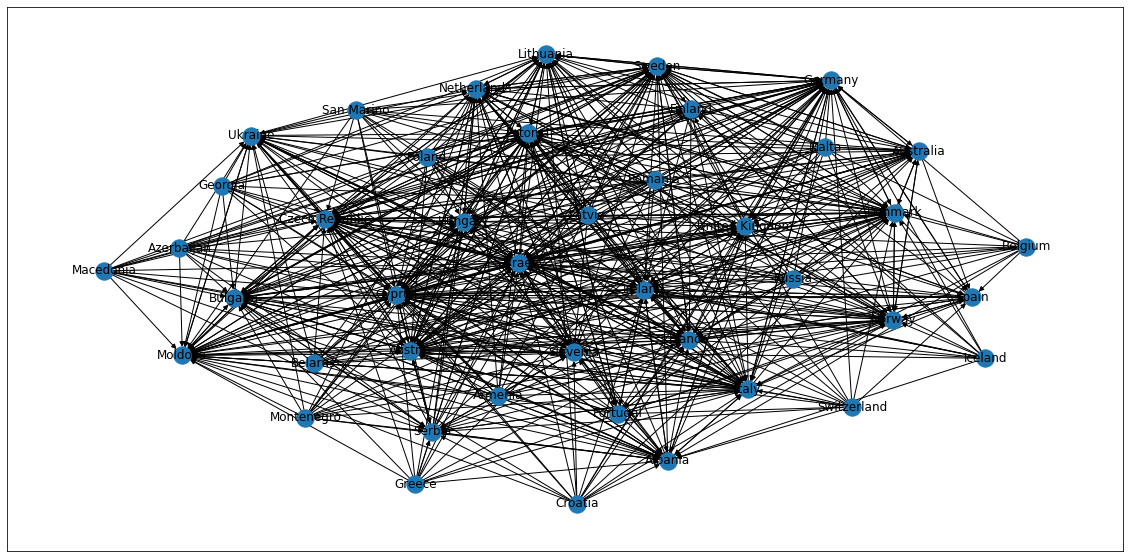

In [11]:
nx.draw_networkx(Gsub)

(array([16.,  1.,  3.,  2.,  3.,  5.,  4.,  1.,  4.,  4.]),
 array([13. , 17.5, 22. , 26.5, 31. , 35.5, 40. , 44.5, 49. , 53.5, 58. ]),
 <a list of 10 Patch objects>)

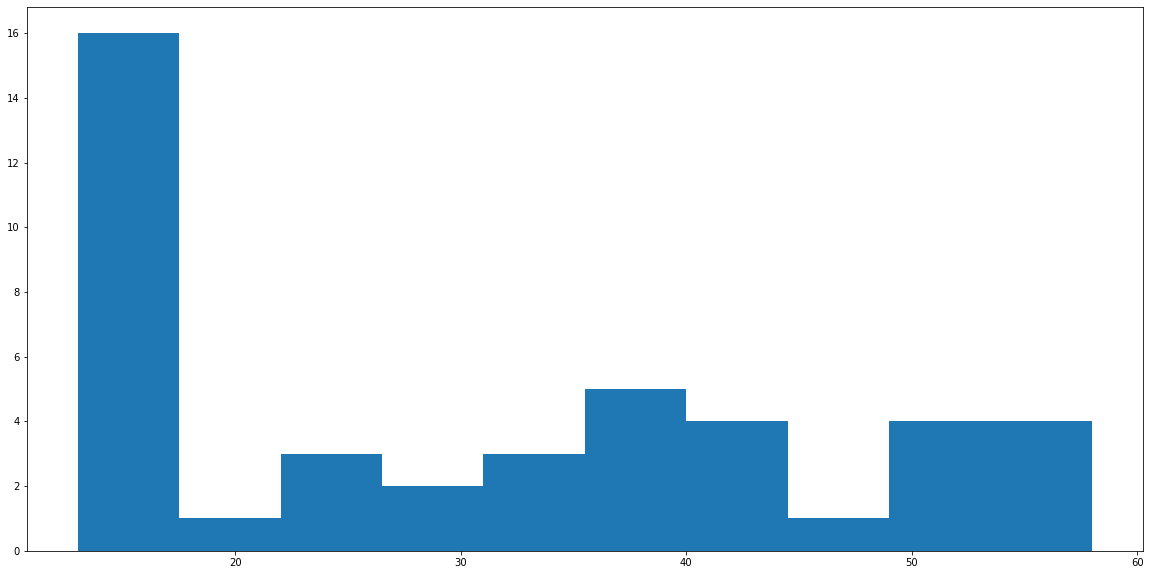

In [12]:
plt.hist(dict(Gsub.degree()).values())

Tuy nhiên điểm số mới là thứ quyết định sự thắng bại

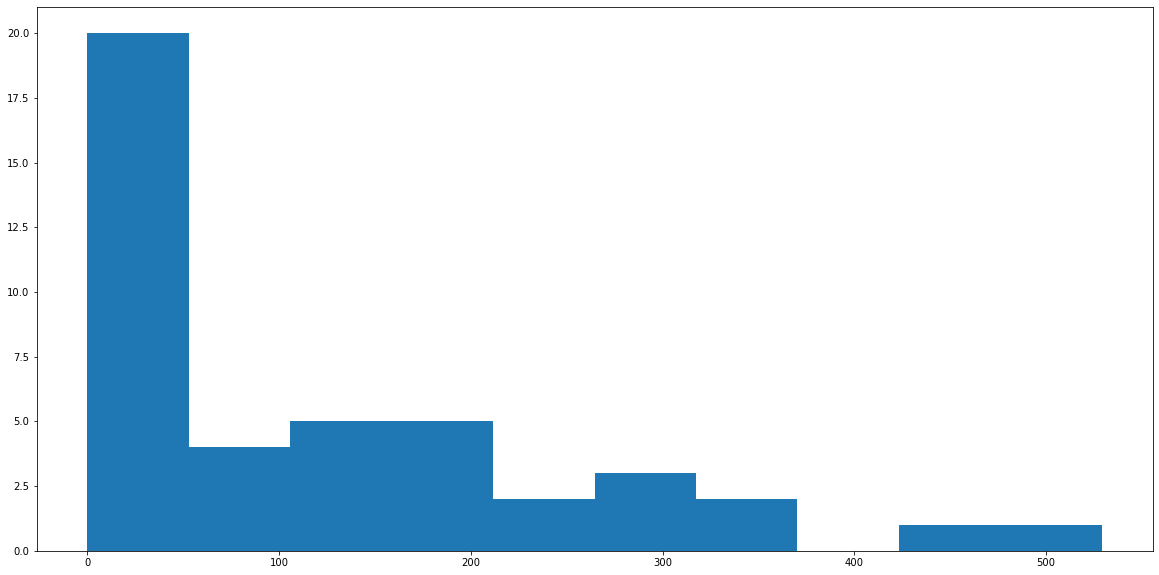

In [13]:
h = plt.hist(dict(G.in_degree(weight='points')).values())

# DÙNG THUẬT TOÁN NETWORKX ĐỂ PHÂN TÍCH

## Geometric centrality

In [14]:
deg_cen_points = dict(G.in_degree(weight='points'))
{k:deg_cen_points[k] for k in deg_cen_points if deg_cen_points[k]==max(deg_cen_points.values())}

{'Israel': 529}

In [15]:
closeness = dict(nx.closeness_centrality(Gsub))
{k:closeness[k] for k in closeness if closeness[k]==max(closeness.values())}

{'Cyprus': 1.0}

In [16]:
deg_centrality  = dict(nx.degree_centrality(Gsub))
{k:deg_centrality[k] for k in deg_centrality if deg_centrality[k]==max(deg_centrality.values())}

{'Israel': 1.380952380952381, 'Cyprus': 1.380952380952381}

In [17]:
deg_centrality  = dict(nx.out_degree_centrality(Gsub))
{k:deg_centrality[k] for k in deg_centrality if deg_centrality[k]==max(deg_centrality.values())}

{'France': 0.45238095238095233}

In [18]:
deg_centrality  = dict(nx.in_degree_centrality(Gsub))
{k:deg_centrality[k] for k in deg_centrality if deg_centrality[k]==max(deg_centrality.values())}

{'Cyprus': 1.0}

## Spectral centrality measures

In [19]:
page_rank = dict(nx.pagerank(Gsub,weight='points'))
{k:page_rank[k] for k in page_rank if page_rank[k]==max(page_rank.values())}

{'Israel': 0.09068767468630147}

In [20]:
eigenvector = dict(nx.eigenvector_centrality(Gsub))
{k:eigenvector[k] for k in eigenvector if eigenvector[k]==max(eigenvector.values())}

{'Cyprus': 0.29155293399835497}

## Meansures of centrality

thể hiện mức độ trung tâm của node, nếu node tương tác với càng nhiều node thì giá trị càng lớn

In [21]:
between = dict(nx.betweenness_centrality(Gsub))
{k:between[k] for k in between if between[k]==max(between.values())}

{'Israel': 0.02243762818675711}

In [22]:
clustering = dict(nx.clustering(Gsub))
{k:clustering[k] for k in clustering if clustering[k]}

{'Albania': 0.4702572347266881,
 'Israel': 0.42547342700061086,
 'Cyprus': 0.4315821624923641,
 'Austria': 0.5037190082644628,
 'Germany': 0.4498587570621469,
 'Italy': 0.42263374485596705,
 'Czech Republic': 0.4565371024734982,
 'Sweden': 0.4421553090332805,
 'Estonia': 0.4566151202749141,
 'Denmark': 0.46191756272401435,
 'Moldova': 0.4593094944512947,
 'Lithuania': 0.5167427701674278,
 'France': 0.4524608501118568,
 'Bulgaria': 0.4864864864864865,
 'Norway': 0.4655448717948718,
 'Ireland': 0.5129950495049505,
 'Ukraine': 0.5009578544061303,
 'Netherlands': 0.5327743902439024,
 'Serbia': 0.5386533665835411,
 'Australia': 0.5182341650671785,
 'Hungary': 0.5813204508856683,
 'Slovenia': 0.528322440087146,
 'Spain': 0.6328413284132841,
 'United Kingdom': 0.5722610722610723,
 'Finland': 0.698237885462555,
 'Portugal': 0.6453744493392071,
 'Belarus': 0.6791666666666667,
 'Belgium': 0.7756410256410257,
 'Croatia': 0.6583333333333333,
 'Macedonia': 0.7032967032967034,
 'Greece': 0.730769230

In [23]:
import functools
nodeMeasures = {
    'pagerank':nx.pagerank(Gsub,weight='points', max_iter=1000),
    'eigevector':nx.algorithms.centrality.eigenvector_centrality(Gsub,max_iter=1000),
    'degree':nx.algorithms.centrality.degree_centrality(Gsub),
    'betweenness':nx.algorithms.centrality.betweenness_centrality(Gsub),
    'closeness':nx.algorithms.centrality.closeness_centrality(Gsub),
};

nodeMeasures = [pd.DataFrame(nodeMeasures[v].items(), columns=['country',v]) for v in nodeMeasures]

nodeMeasures = functools.reduce(lambda  left,right: pd.merge(left,right,on='country', how='outer'), nodeMeasures)

def pond(x):
    x['pond'] = (1+x[['pagerank','degree','closeness','betweenness']]).cumprod()[-1]-1;
    return x;

nodeMeasures = nodeMeasures.apply(pond,axis=1)

nodeMeasures.corr().style.background_gradient().format("{:.1%}")

,pagerank,eigevector,degree,betweenness,closeness,pond
pagerank,100.0%,93.6%,94.6%,93.1%,86.6%,95.1%
eigevector,93.6%,100.0%,98.3%,92.6%,95.2%,98.5%
degree,94.6%,98.3%,100.0%,95.5%,94.8%,99.5%
betweenness,93.1%,92.6%,95.5%,100.0%,86.5%,94.4%
closeness,86.6%,95.2%,94.8%,86.5%,100.0%,96.8%
pond,95.1%,98.5%,99.5%,94.4%,96.8%,100.0%


In [24]:
nodeMeasures\
    .sort_values('pond',ascending=False).set_index('country').round(2)\
    .style.background_gradient(axis=0).format("{:.5}")

,pagerank,eigevector,degree,betweenness,closeness,pond
country,,,,,,
Israel,0.09,0.28,1.38,0.02,0.98,4.25
Cyprus,0.06,0.29,1.38,0.02,1.0,4.15
Germany,0.07,0.28,1.29,0.01,0.93,3.78
Czech Republic,0.06,0.27,1.29,0.02,0.89,3.66
Sweden,0.05,0.26,1.21,0.01,0.89,3.48
Austria,0.07,0.29,1.19,0.01,0.86,3.42
Italy,0.05,0.22,1.19,0.01,0.86,3.34
Estonia,0.04,0.25,1.17,0.02,0.84,3.23
Denmark,0.04,0.24,1.14,0.01,0.82,3.13



# Tiến hành thêm lá cờ vào bộ dữ liệu để thiết kế

In [25]:
countries = pd.read_csv('countries.csv',index_col='Country',sep=",", encoding='cp1252')

In [26]:
countries.head()

,cc2,cc3,numeric,latitude,longitude
Country,,,,,
Afghanistan,AF,AFG,4,33.0000,65.0
Albania,AL,ALB,8,41.0000,20.0
Algeria,DZ,DZA,12,28.0000,3.0
American Samoa,AS,ASM,16,-14.3333,-170.0
Andorra,AD,AND,20,42.5000,1.6


In [27]:
pos_geo = {  node: 
           ( max(-10,min(countries.loc[node]['longitude'],55)), # fixing scale
             max(countries.loc[node]['latitude'],25)) #fixing scale
               for node in G.nodes() }

In [28]:
pos_geo = {}
for node in G.nodes():
    pos_geo[node] = (
                    max(-10,min(countries.loc[node]['longitude'],55)), # fixing scale
                    max(countries.loc[node]['latitude'],25) #fixing scale
    )

# DÙNG THUẬT TOÁN VẼ KMEANS

In [29]:
shells = pd.merge(
    pd.DataFrame(pos_geo.items(), columns=['country','cluster']),
    pd.DataFrame(dict(Gsub.degree()).items(), columns=['country','degree'])
).sort_values(['cluster','degree'])['country'].values

In [30]:
influence = nx.pagerank(Gsub,weight='points')

In [31]:
flags = {}
flag_color = {}
for node in tqdm.tqdm_notebook(G.nodes()):
    flags[node] = 'flags/'+(countries.loc[node]['cc3']).lower().replace(' ','')+'.png'   
    flag_color[node] =  ColorThief(flags[node]).get_color(quality=1)

In [32]:
def RGB(red,green,blue): 
    return '#%02x%02x%02x' % (red,green,blue)

Tiến hành vẽ

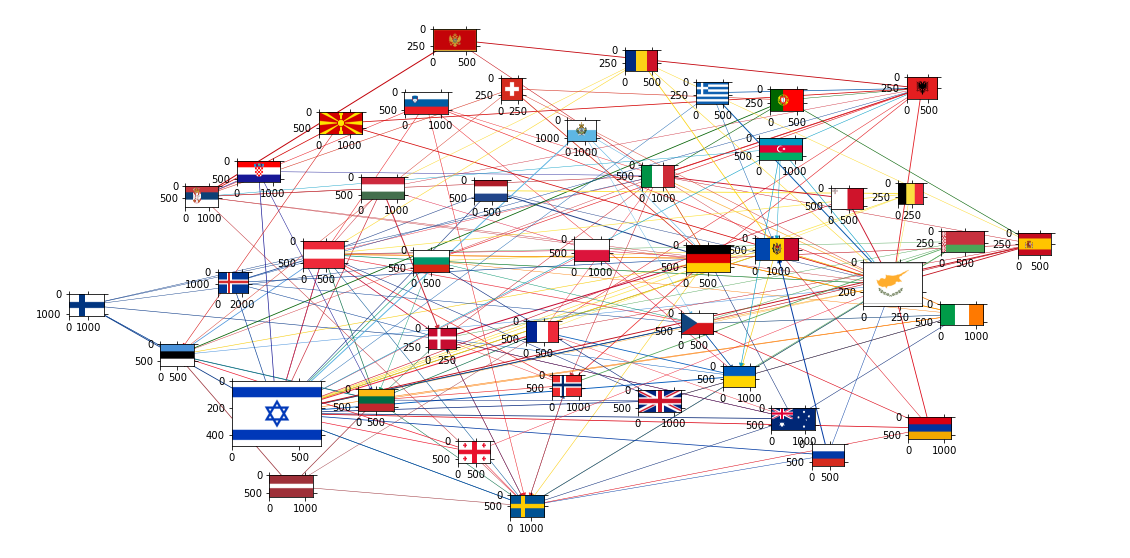

In [33]:
ax=plt.gca()
fig=plt.gcf()
plt.axis('off')

pos = nx.layout.fruchterman_reingold_layout(G,k=1,weight = 'points',iterations=1000,scale = 2)
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform

tick_params = {'top':'off', 'bottom':'off', 'left':'off', 'right':'off','labelleft':'off', 'labelbottom':'off'}
styles = ['dotted','dashdot','dashed','solid'] 

for e in G.edges(data=True):
    width = e[2]['points']/24 #normalize by max points
    style=styles[int(width*3)]
    if width>0.4: #filter small votes
        nx.draw_networkx_edges(G,pos,edgelist=[e],width=width,style=style, edge_color = RGB(*flag_color[e[0]]) )
for node in G.nodes():    
    imsize = max((0.3*G.in_degree(node,weight='points')/max(dict(G.in_degree(weight='points')).values()))**2,0.03)
    # size is proportional to the votes
    flag = mpl.image.imread(flags[node])
    
    (x,y) = pos[node]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    
    country = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    country.imshow(flag)
    country.set_aspect('equal')
    country.tick_params(**tick_params)   